# 1. Introduction to Time Series

This classes are based on [Avishek Pal, PKS Prakash (2017). Practical time series analysis: master time series data processing[...]](https://universidadefe957-my.sharepoint.com/:b:/g/personal/paulo_firmino_ufca_edu_br/EY6upDI8ktJKnCQlqns9kz4BhFko1dcOehhwcyw7JE4JuQ?e=WMhXbd). The codes of the book can be found [here](https://github.com/PacktPublishing/Practical-Time-Series-Analysis/tree/master/.)

## General Imports

In [4]:
#IMPORT
from __future__ import print_function#to enable using print as a function for readers who might be using a 2.x version of Python
import os
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns#READING DATA
#
# os.chdir('D:\Practical Time Series')
# data = pd.read_csv('..\..\data\TimeSeries\WDIData.csv')
# display(data)

## General trend

When a time series exhibits an upward or downward movement in the long run, it is said to
have a general trend. 

The data taken as example can be accessed [here](https://github.com/PacktPublishing/Practical-Time-Series-Analysis/blob/master/Data%20Files/Monthly_CO2_Concentrations.xlsx). It shows CO2 concentrations in air measured during
1974 through 1987.

In [5]:
# %pip install openpyxl
co2 = pd.read_excel(io='..\..\data\TimeSeries\Monthly_CO2_Concentrations.xlsx', 
                    converters={'Year': np.int32, 'Month': np.int32})
co2 = co2.reindex(columns=['Year', 'Month', 'CO2'])
display(co2.head(-2))

,Year,Month,CO2
0,1974,5,333.13
1,1974,6,332.09
2,1974,7,331.10
3,1974,8,329.14
4,1974,9,327.36
...,...,...,...
167,1987,3,349.29
168,1987,4,350.91
169,1987,5,351.71
170,1987,6,350.94


In [6]:
df = pd.DataFrame({'year': co2.Year,
                   'month': co2.Month,#}),
                    'day': pd.Series([28]*len(co2.Year))})
df
co2['date'] = pd.to_datetime(df[['year', 'month', 'day']])
# print(type(co2.date[0]))
# co2.reindex(index='date')
display(co2.head(-2))

,Year,Month,CO2,date
0,1974,5,333.13,1974-05-28
1,1974,6,332.09,1974-06-28
2,1974,7,331.10,1974-07-28
3,1974,8,329.14,1974-08-28
4,1974,9,327.36,1974-09-28
...,...,...,...,...
167,1987,3,349.29,1987-03-28
168,1987,4,350.91,1987-04-28
169,1987,5,351.71,1987-05-28
170,1987,6,350.94,1987-06-28


In [7]:
co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Year    161 non-null    object        
 1   Month   161 non-null    object        
 2   CO2     161 non-null    float64       
 3   date    161 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.6+ KB


In [8]:
co2 = co2[(~pd.isnull(co2['CO2']))&\
          (~pd.isnull(co2['Year']))&\
          (~pd.isnull(co2['Month']))]
co2.sort_values(by=['Year', 'Month'], inplace=True)
co2.shape

(161, 4)

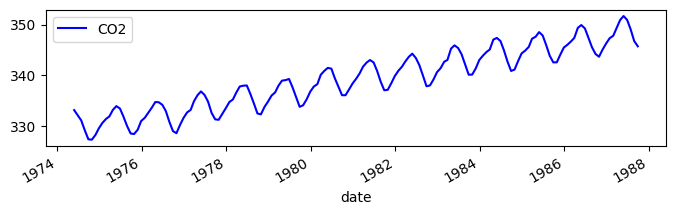

In [9]:
figsize = (8, 2);
# plt.figure(figsize=figsize);
co2.plot(x='date', y='CO2', color='b', figsize=figsize);
# plt.xlabel('Time');
# plt.ylabel('CO2 concentratition');
# plt.xticks(rotation=30);

### Linear trend model

In [10]:
from sklearn.linear_model import LinearRegression
trend_model = LinearRegression(fit_intercept=True)
trend_model.fit(np.array(co2.index).reshape((-1,1)), co2['CO2'])
print('Trend model coefficient={} and intercept={}'.format(trend_model.coef_[0],
    trend_model.intercept_))

Trend model coefficient=0.11182207854546038 and intercept=329.4554222337025


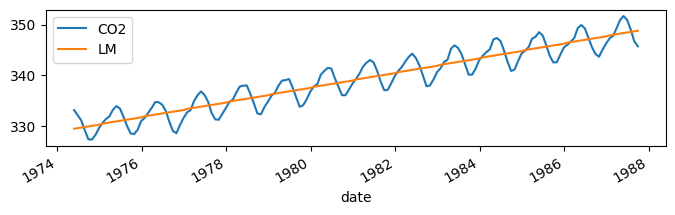

In [11]:
co2['LM'] = trend_model.predict(np.array(co2.index).reshape((-1,1)))
co2.plot(x='date', y=['CO2', 'LM'], figsize=figsize);

#### Model residuals

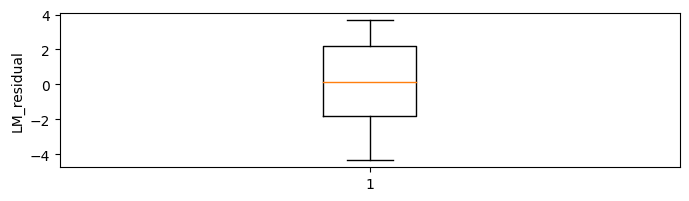

In [12]:
co2['LM_res'] = co2['CO2'].subtract(
    trend_model.predict(np.array(co2.index).reshape((-1,1))))
plt.figure(figsize=figsize);
plt.boxplot(co2['LM_res'])
plt.ylabel('LM_residual');

## Seasonality

Seasonality manifests as repetitive and period variations in a time series. In most cases,
exploratory data analysis reveals the presence of seasonality. 

In [13]:
co2.columns

Index(['Year', 'Month', 'CO2', 'date', 'LM', 'LM_res'], dtype='object')

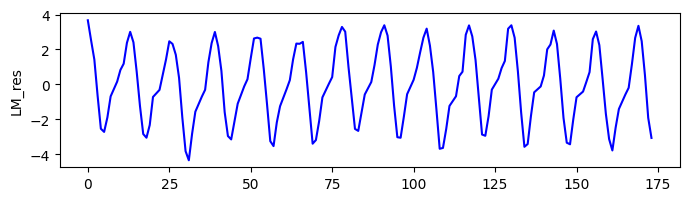

In [14]:
# plt.figure(figsize=figsize);
# residualsSeries = pd.Series(data=residuals, index=co2.date)
co2['LM_res'].plot(color='b', figsize=figsize, ylabel='LM_res');
# plt.title('Residuals of trend model for CO2 concentrations');
# plt.xlabel('time');
# plt.ylabel('LM residual');
# plt.xticks(rotation=90);

A practical technique of determining seasonality is through exploratory data analysis
through the following plots:
- Run sequence plot
- Seasonal sub series plot
- Multiple box plots

### Run sequence plot

A simple run sequence plot of the original time series with time on x-axis and the variable
on y-axis is good for indicating the following properties of the time series:
- Movements in mean of the series
- Shifts in variance
- Presence of outliers

As follows one has a sin seasonal shape funciton: 
$u_t = a_t \times sin({f}_t)$.
- $a_t \equiv `Amplitude'$ (thus, the difference between maximum and minimum of $u$ among waves).
- ${f}_t \equiv `Frequency'$ (thus, the lesser the $f_t$ the lesser the frequency of peaks).

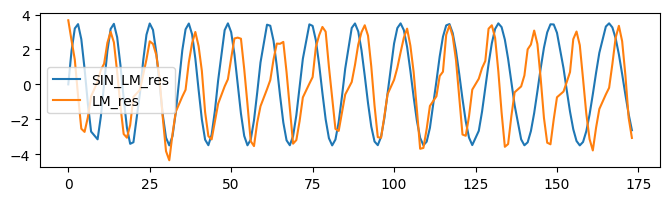

In [15]:
# from scipy.stats import norm
def polynomialFunction(x, p):
    """Allows the computation of polynomial time-dependent shapes
    for the seasonal amplitude, frequency, and variance components.   

    Args:
        x (vector of floats): the time-values for which the time-dependent 
        function operates.
        p (list of floats): the polynomial coefficients.

    Returns:
        list of floats: the predictions of the polynomial function.
    """
    ret = [p[0]]*len(x)
    for i in range(1, len(p)):
        ret += p[i]*x**i# + p[2]*x*x
    # print(ret)
    return ret
def getSeasonalModelPrediction(x, *p):
    nCoefs = round(len(p)/2)
    p_a = p[:nCoefs]; p_f = p[nCoefs:]; #p_v = p[2*nCoefs:];
    # print('p_a:', p_a); print('p_f:', p_f); print('p_v:', p_v)
    a = polynomialFunction(x, p_a)
    f = polynomialFunction(x, p_f)
    # v = polynomialFunction(x, p_v)
    u = []; #e = [0]*len(x);
    for t in range(len(x)):
        # if v[t] > 0:
            # e[t] = norm.rvs(loc=0, scale=v[t], size=1, random_state=t)[0]#1#t
        u_t = a[t]*np.sin(f[t]*x[t])# + e[t]
        u.append(u_t)
    return u
def appendSeasonalModel(x, p_a, p_f, modelNm, df):
    """Build a Seasonal model and append its predictions to the original 
    data frame.

        Args:
        a (list of floats):  the time-dependent Amplitude
        (thus, the difference between maximum and minimum of the time series u among waves).
        (f_0, f_1_t) (float, list of floats):  the frequency of peaks 
        (thus, the lesser the $f_i$ the lesser the frequency of peaks).
        v_t (list of floats):  the error variance time tendency coefficient 
        (thus, the greater the v_t the greater the variance tendency). 
        Usefull for simulation when it is different from zero.
        modelNm (string): the name of the proposed model.
        df (Data frame): The data frame to be updated with the estimates of the 
        proposed seasonal model.

    Returns:
        Data frame: the predictions of the polynomial function.
        """
    p = p_a+ p_f
    u = getSeasonalModelPrediction(x, *p)#p
    df[modelNm] = pd.Series(u, index=df.index)
    return df
co2 = appendSeasonalModel(x = co2.index,  
                          p_a = [3.5, 0],#only a 3.5 constant over time 
                          p_f = [.58, -.0007], #a decreasing linear function (1.05 - .00008t)
                          modelNm = 'SIN_LM_res', df = co2)
co2[['SIN_LM_res', 'LM_res']].plot(kind='line', figsize=figsize);

#### Near optimal seasonal fitting

The previous fit has been bascially hands-on. The ideal is to resort to near optimal solutions. The following codes has been inspired on [this discussion](https://stackoverflow.com/questions/52524919/fourier-series-fit-in-python).

optPars: [ 3.30000000e+00  4.93508401e-40  5.65864059e-01 -6.47544391e-04]


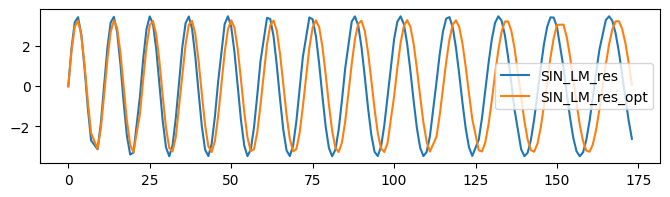

In [16]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# %pip install scipy 
import scipy

optPars, optParsCovariance = scipy.optimize.curve_fit(
    f = getSeasonalModelPrediction, 
    xdata = co2.index, ydata = co2['LM_res'], maxfev=100000,
    # Initial guesses for p_a, p_f, p_v
    p0=[3.5, 0]+#p_a, only a 3.5 constant over time 
       [.58, -.0007], #p_f, a decreasing linear function (.52 - .0008t)
    bounds=([3.3, 0, .5, -.005], [3.6, 0.001, 0.6, -.0001])
)
print('optPars:', optPars)
co2['SIN_LM_res_opt'] = getSeasonalModelPrediction(co2.index, *optPars)
# display(co2.head(2))
co2[['SIN_LM_res', 'SIN_LM_res_opt']].plot(figsize=figsize);

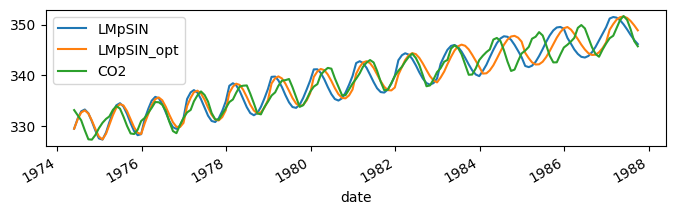

In [17]:
co2['LMpSIN'] = co2['LM'].add(co2['SIN_LM_res'])
co2['LMpSIN_opt'] = co2['LM'].add(co2['SIN_LM_res_opt'])
co2.plot(x='date', y=['LMpSIN', 'LMpSIN_opt', 'CO2'], figsize=figsize);

### More boosting

In [18]:
co2.columns

Index(['Year', 'Month', 'CO2', 'date', 'LM', 'LM_res', 'SIN_LM_res',
       'SIN_LM_res_opt', 'LMpSIN', 'LMpSIN_opt'],
      dtype='object')

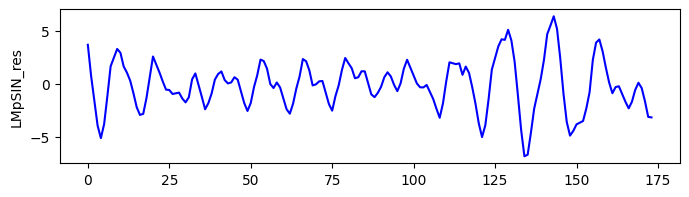

In [19]:
co2['LMpSIN_opt_res'] = co2['CO2'].subtract(co2['LMpSIN_opt'])
co2['LMpSIN_opt_res'].plot(color='b', figsize=figsize, ylabel='LMpSIN_res');

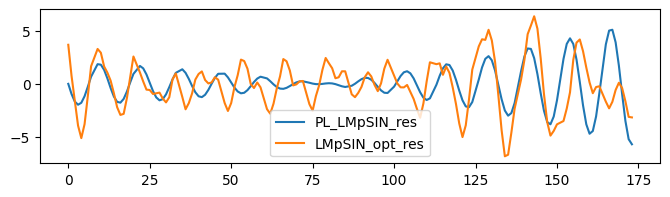

In [20]:
co2 = appendSeasonalModel(x = co2.index,  
                          p_a = [-2, .01, .0002],#a convex parabola over time 
                          p_f = [0.5, .0, .0], #a decreasing linear function (.05 - .00008t)
                          modelNm = 'PL_LMpSIN_res', df = co2)
co2[['PL_LMpSIN_res', 'LMpSIN_opt_res']].plot(kind='line', figsize=figsize);

optPars: [-1.04647389e+00  9.99999997e-03  1.00000000e-04  4.97186573e-01
  2.43940956e-20  1.36794833e-20]


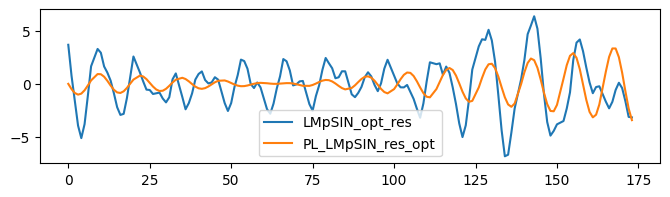

In [21]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# %pip install scipy 
import scipy

optPars, optParsCovariance = scipy.optimize.curve_fit(
    f = getSeasonalModelPrediction, 
    xdata = co2.index, ydata = co2['LMpSIN_opt_res'], maxfev=100000,
    # Initial guesses for p_a, p_f, p_v
    p0 = [-2, .01, .0002]+#p_a: a convex parabola over time 
         [0.5, .0, .0], #p_f: a decreasing linear function (.05 - .00008t)
    bounds=([-2.5, 0.001, .0001, 0.3, .0, .0], 
            [-1., 0.01, .005, 0.7, .01, .01])
)
print('optPars:', optPars)
co2['PL_LMpSIN_res_opt'] = getSeasonalModelPrediction(co2.index, *optPars)
# display(co2.head(2))
co2[['LMpSIN_opt_res', 'PL_LMpSIN_res_opt']].plot(figsize=figsize);

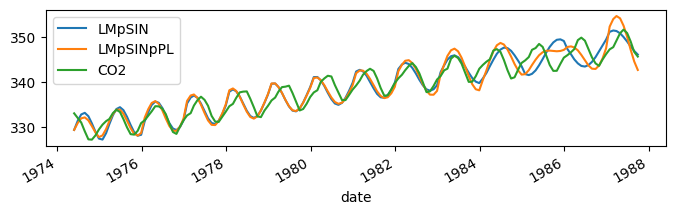

In [22]:
co2['LMpSINpPL'] = co2['LMpSIN'].add(co2['PL_LMpSIN_res_opt'])
co2.plot(x='date', y=['LMpSIN', 'LMpSINpPL', 'CO2'], figsize=figsize);

At some moment the analyst must stop modeling. Some quality criteria must be considered...

### More alternatives for seasonality evaluation

#### Seasonal sub series plot

For a known periodicity of seasonal variations, seasonal sub series redraws the original
series over batches of successive time periods. For example, the periodicity in the CO2
concentrations is 12 months and based on this a seasonal sub series plots on mean and
standard deviation of the residuals are important.

A seasonal sub series reveals two properties:
- Variations within seasons as within a batch of successive months
- Variations between seasons as between batches of successive months

##### Apending Calendar Features

In [23]:
calendarFeatures = [#'daycount', 'dayofyear', 
                    'month', 'quarter', 'year']
def appendCalendarFeatures(df, startDayCount = 0, dateColNm = 'date'):
    """Create time series features based on time series dates.

    Args:
        df (DataFrame): The data set under consideration.
        startDayCount (int, optional): The index of the first day. Defaults to 0.

    Returns:
        DataFrame: The updated data set, now with the calendar features.
    """
    # df = df.copy()
    if 'hour' in calendarFeatures:
        df['hour'] = df[dateColNm].dt.hour
    if 'daycount' in calendarFeatures:
        df['daycount'] = range(startDayCount, startDayCount+len(df))
    if 'dayofweek' in calendarFeatures:
        df['dayofweek'] = df[dateColNm].dt.dayofweek#0 represents monday
    if 'dayofmonth' in calendarFeatures:
        df['dayofmonth'] = df[dateColNm].dt.day
    if 'dayofyear' in calendarFeatures:
        df['dayofyear'] = df[dateColNm].dt.dayofyear
    if 'month' in calendarFeatures:
        df['month'] = df[dateColNm].dt.month
    if 'quarter' in calendarFeatures:
        df['quarter'] = df[dateColNm].dt.quarter
    if 'year' in calendarFeatures:
        df['year'] = df[dateColNm].dt.year
    if 'weekofyear' in calendarFeatures:
        df['weekofyear'] = df[dateColNm].dt.isocalendar().week
    print(">>> Calendar Features Appended: "+str(calendarFeatures))
    display(df.head(2))
    return df
co2 = appendCalendarFeatures(co2)

>>> Calendar Features Appended: ['month', 'quarter', 'year']


,Year,Month,CO2,date,LM,LM_res,SIN_LM_res,SIN_LM_res_opt,LMpSIN,LMpSIN_opt,LMpSIN_opt_res,PL_LMpSIN_res,PL_LMpSIN_res_opt,LMpSINpPL,month,quarter,year
0,1974,5,333.13,1974-05-28,329.455422,3.674578,0.000000,0.000000,329.455422,329.455422,3.674578,-0.000000,-0.000000,329.455422,5,2,1974
1,1974,6,332.09,1974-06-28,329.567244,2.522756,1.916034,1.767476,331.483278,331.334720,0.755280,-0.953961,-0.494303,330.988975,6,2,1974


In [24]:
seasonal_sub_series_data = co2.groupby(by=['year','quarter'])['PL_LMpSIN_res_opt'].\
    aggregate([np.mean, np.std])
seasonal_sub_series_data.columns = ['Quarterly Mean', 'Quarterly SD']
display(seasonal_sub_series_data.head(5))

Quarterly Mean  Quarterly SD
year quarter                              
1974 2             -0.247152      0.349525
     3             -0.930348      0.076758
     4             -0.146096      0.464484
1975 1              0.832990      0.139546
     2             -0.144295      0.420330

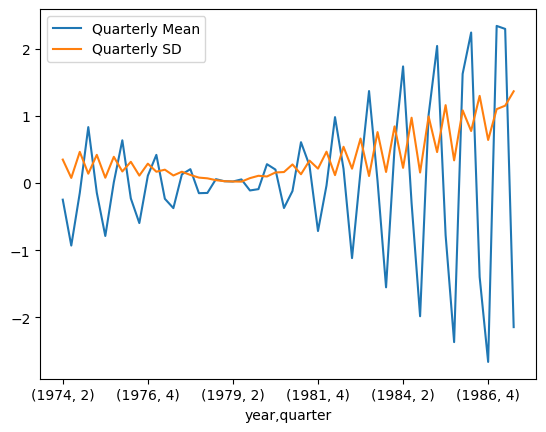

In [25]:
seasonal_sub_series_data[['Quarterly Mean', 'Quarterly SD']].plot();

#### Multiple box plots

The seasonal sub series plot can be more informative when redrawn with seasonal box plots
as shown in the following figure. A box plot displays both central tendency and dispersion
within the seasonal data over a batch of time units. Besides, separation between two
adjacent box plots reveal the within season variations.

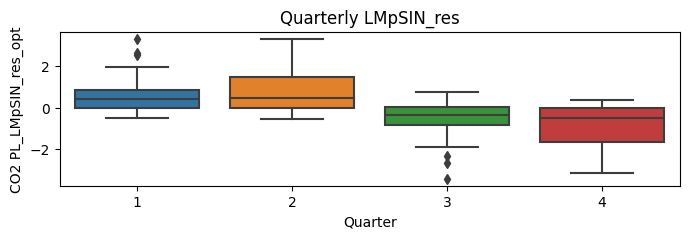

In [26]:
plt.figure(figsize=figsize)
g = sns.boxplot(data=co2, y='PL_LMpSIN_res_opt', x='quarter')
g.set_title('Quarterly LMpSIN_res')
g.set_xlabel('Quarter')
g.set_ylabel('CO2 PL_LMpSIN_res_opt');

### Cyclical changes

Cyclical changes are movements observed after every few units of time, but they occur less
frequently than seasonal fluctuations. Unlike seasonality, cyclical changes might not have a
fixed period of variations. Besides, the average periodicity for cyclical changes would be
larger (most commonly in years), whereas seasonal variations are observed within the same
year and corresponds to annual divisions of time such as seasons, quarters, and periods of
festivity and holidays and so on. Thus, A long run plot of the time series is required to identify cyclical changes that can occur. 

In [27]:
inflation = pd.read_excel(io='..\..\data\TimeSeries\inflation-consumer-prices-annual.xlsx', 
                    parse_dates=['Year'], index_col='Year')
inflation.head(-1)

c:\Users\praf6\OneDrive\UFCA\Ensino\CRAN R_aulas\RClasses\P\.conda\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,India,United States
Year,,
1960-01-01,1.783265,1.509929
1961-01-01,1.752022,1.075182
1962-01-01,3.576159,1.116071
1963-01-01,2.941176,1.214128
1964-01-01,13.354037,1.308615
1965-01-01,9.479452,1.668461
1966-01-01,10.810811,2.991001
1967-01-01,13.053297,2.775636
1968-01-01,2.996404,4.217721


The following figure illustrates cyclical changes occurring in inflation of consumer price
index (CPI) for India and United States over the period of 1960 through 2016. Both the
countries exhibit cyclical patterns in CPI inflation, which is roughly over a period of 2-2.5
years. Moreover, CPI inflation of India has larger variations pre-1990 than that seen after
1990.

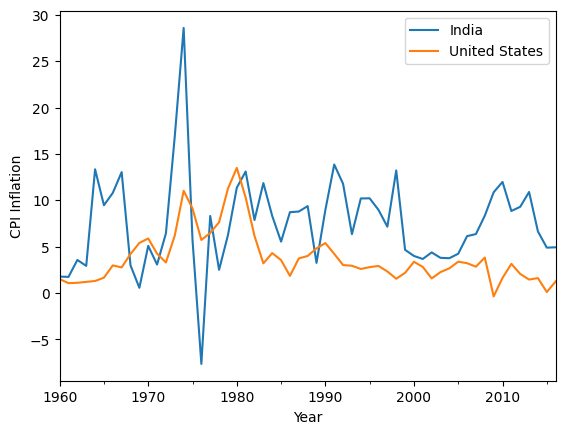

In [28]:
inflation[['India', 'United States']].plot(ylabel='CPI Inflation');

Particularmente não vejo muito ciclicidade...

## Unexpected variations

Referring to our model that expresses a time series as a sum of four components, it is
noteworthy that in spite of being able to account for the three other components, we might
still be left with an irreducible error component that is random and does not exhibit
systematic dependency on the time index. This fourth component reflects unexpected
variations in the time series. Unexpected variations are stochastic and cannot be framed in a
mathematical model for a definitive future prediction. This type of error is due to lack of
information about explanatory variables that can model these variations or due to presence
of a random noise.

## Another Time Series simple models

### Zero Mean Model

### Random Walk

A random walk is given as a sum of $n$ iids, which has zero mean and constant variance.
Based on this definition, the realization of a random walk at time index $t$ is given by the sum $s_t = x_1 + x_2 + ... + x_n$. 

In this way, let $X_t$ and $S_t$ be the random variables from which the instances $x_t$ and $s_t$ are realized, in this order. Thus, $\{X_t: t = 0, 1, \dots\}$ and $\{S_t: t = 0, 1, \dots\}$ are named stochastic processes and $\{s_t: t = 0, 1, \dots\}$ and $\{s_t: t = 0, 1, \dots\}$ are time series.

The random walk is important because if such behavior is found in a time series, it can be easily reduced to zero mean model by taking differences of the observations from two
consecutive time indices as $s_t - s_{t-1} = x_t$ comes from an iid random variable with zero mean and constant variance.

The transformation $\delta_t = x_t - x_{t-1}$ is also known as differentiation of degree 1.

$\delta^2_t = \delta_t - \delta_{t-1}$